In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn streamlit


Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd

df = pd.read_csv(r"C:\Users\nancy\Downloads\taxi_fare (1).csv")  # replace with actual file path
print(df.head())


   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2016-03-01 00:00:00   2016-03-01 00:07:55                1   
1         1  2016-03-01 00:00:00   2016-03-01 00:11:06                1   
2         2  2016-03-01 00:00:00   2016-03-01 00:31:06                2   
3         2  2016-03-01 00:00:00   2016-03-01 00:00:00                3   
4         2  2016-03-01 00:00:00   2016-03-01 00:00:00                5   

   pickup_longitude  pickup_latitude  RatecodeID store_and_fwd_flag  \
0        -73.976746        40.765152           1                  N   
1        -73.983482        40.767925           1                  N   
2        -73.782021        40.644810           1                  N   
3        -73.863419        40.769814           1                  N   
4        -73.971741        40.792183           3                  N   

   dropoff_longitude  dropoff_latitude  payment_type  fare_amount  extra  \
0         -74.004265         40.746128        

In [7]:
df.info()
df.describe()
df.isnull().sum()
df.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212345 entries, 0 to 212344
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               212345 non-null  int64  
 1   tpep_pickup_datetime   212345 non-null  object 
 2   tpep_dropoff_datetime  212345 non-null  object 
 3   passenger_count        212345 non-null  int64  
 4   pickup_longitude       212345 non-null  float64
 5   pickup_latitude        212345 non-null  float64
 6   RatecodeID             212345 non-null  int64  
 7   store_and_fwd_flag     212345 non-null  object 
 8   dropoff_longitude      212345 non-null  float64
 9   dropoff_latitude       212345 non-null  float64
 10  payment_type           212345 non-null  int64  
 11  fare_amount            212345 non-null  float64
 12  extra                  212345 non-null  float64
 13  mta_tax                212345 non-null  float64
 14  tip_amount             212345 non-nu

0

In [9]:
import numpy as np
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

df['trip_distance'] = df.apply(lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'],
                                                     row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
df['pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['pickup_day'] = df['pickup_datetime'].dt.day_name()
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['am_pm'] = df['pickup_hour'].apply(lambda x: 'AM' if x < 12 else 'PM')
df['is_night'] = df['pickup_hour'].apply(lambda x: 1 if x < 6 or x > 22 else 0)


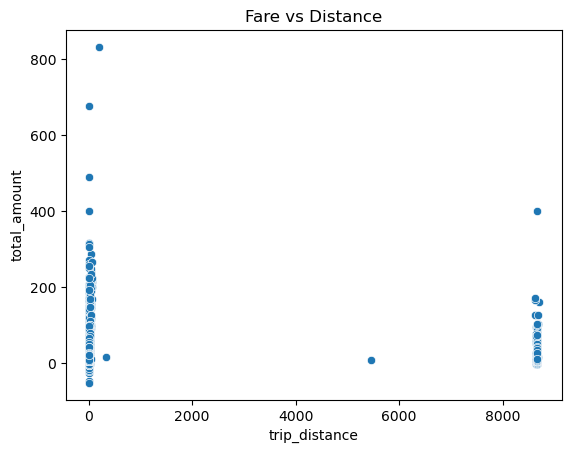

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x='trip_distance', y='total_amount')
plt.title('Fare vs Distance')
plt.show()


In [15]:
from sklearn.preprocessing import LabelEncoder

df = df[df['trip_distance'] < df['trip_distance'].quantile(0.99)]
df = df[df['total_amount'].notnull() & (df['total_amount'] > 0)]
df['log_fare'] = np.log1p(df['total_amount'])


le = LabelEncoder()
df['payment_type_encoded'] = le.fit_transform(df['payment_type'])


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

X = df[['trip_distance', 'passenger_count', 'pickup_hour', 'is_night']]
y = df['total_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RF': RandomForestRegressor(),
    'GB': GradientBoostingRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"{name} R2: {r2_score(y_test, preds):.2f} | RMSE: {root_mean_squared_error(y_test, preds):.2f}")


Linear R2: 0.71 | RMSE: 6.06
Ridge R2: 0.71 | RMSE: 6.06
Lasso R2: 0.70 | RMSE: 6.09
RF R2: 0.70 | RMSE: 6.18
GB R2: 0.75 | RMSE: 5.60


In [23]:
# 1️⃣ Import necessary libraries
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score
import numpy as np


param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}


gbr = GradientBoostingRegressor(random_state=42)


random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_grid,
    n_iter=20,           
    cv=3,                
    n_jobs=-1,           
    verbose=2,
    random_state=42
)


X_sample = X_train.sample(frac=0.5, random_state=42)
y_sample = y_train.loc[X_sample.index]


random_search.fit(X_sample, y_sample)


print("Best Parameters Found:\n", random_search.best_params_)


best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nBest Tuned Gradient Boosting Model:\nR²: {r2:.4f} | RMSE: {rmse:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters Found:
 {'subsample': 1.0, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.05}

Best Tuned Gradient Boosting Model:
R²: 0.7489 | RMSE: 5.6134


In [25]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", random_search.best_params_)
print(f"R2: {r2:.4f} | RMSE: {rmse:.4f}")

Best Parameters: {'subsample': 1.0, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.05}
R2: 0.7489 | RMSE: 5.6134


In [29]:
import pickle
with open("fare_prediction_model.pkl", "wb") as f:
    pickle.dump(best_model, f)


In [31]:
import os
print(os.getcwd())


C:\Users\nancy


In [37]:



import pickle
import numpy as np
from sklearn.metrics import root_mean_squared_error, r2_score


model_path = "fare_prediction_model.pkl"

with open(model_path, "rb") as f:
    loaded_model = pickle.load(f)

print("✅ Model loaded successfully.")


try:
    y_pred_loaded = loaded_model.predict(X_test)
    rmse_loaded = root_mean_squared_error(y_test, y_pred_loaded)
    r2_loaded = r2_score(y_test, y_pred_loaded)

    print(f"Loaded Model Performance — R²: {r2_loaded:.4f} | RMSE: {rmse_loaded:.4f}")
except:
    print("No X_test and y_test found. Skipping test set evaluation.")

import pandas as pd

test_input_df = pd.DataFrame([[12.3, 17, 5, 0]], columns=loaded_model.feature_names_in_)
predicted_fare = loaded_model.predict(test_input_df)

print(f"Predicted Fare: ₹{predicted_fare[0]:.2f}")




✅ Model loaded successfully.
Loaded Model Performance — R²: 0.7489 | RMSE: 5.6134
Predicted Fare: ₹38.42
